In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


# Model Config

In [3]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

import os
import json
from time import perf_counter
import random

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
torch.set_printoptions(precision=4, sci_mode=False)

In [5]:
torch.set_grad_enabled(False)

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
DEVICE, DTYPE = (
    torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    torch.float32,
)
MODEL_NAME = "vgg16"
INPUT_PATH = "img/imagenet/"
OUTPUT_ROOT = "outputs"
OUTPUT_PATH = f"{OUTPUT_ROOT}/{MODEL_NAME}"
OUTPUT_PATH_DEBUG = f"{OUTPUT_PATH}/debug"

labels_path = "models/imagenet_class_index.json"

os.makedirs(OUTPUT_PATH_DEBUG, exist_ok=True)

model = getattr(models, MODEL_NAME)(weights="DEFAULT").to(device=DEVICE, dtype=DTYPE)
model = nn.Sequential(
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    model,
    nn.Softmax(dim=1),
)
model.eval()

# Obtain the last convolutional layer
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        last_conv_layer = layer

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to(device=DEVICE, dtype=DTYPE)),
    ]
)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Model {type(model).__name__} total parameters: ", pytorch_total_params)

with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

get_class = lambda id: idx_to_labels[str(id)][0]
get_label = lambda id: idx_to_labels[str(id)][1]

load_image = lambda img_source, transform: transform(Image.open(img_source))

inputs = []
for filename in os.listdir(INPUT_PATH):
    f = os.path.join(INPUT_PATH, filename)
    image = load_image(f, transform)
    inputs.append(image)
inputs = torch.stack(inputs, dim=0)
inputs.shape

Model Sequential total parameters:  138357544


torch.Size([122, 3, 224, 224])

In [8]:
inputs = inputs[:4]
inputs.shape

torch.Size([4, 3, 224, 224])

In [9]:
with torch.no_grad():
    output = model(inputs)
prediction_score, pred_label_idx = map(lambda x: x.squeeze_(), torch.topk(output, 1))

for score, label_idx in zip(prediction_score, pred_label_idx):
    id = label_idx.item()
    predicted_label = get_label(id)
    print(f"Predicted: {predicted_label} ({id}) ({score.item():.4f})")

Predicted: Pekinese (154) (0.6802)
Predicted: bulbul (16) (1.0000)
Predicted: African_elephant (386) (0.4556)
Predicted: Afghan_hound (160) (0.9993)


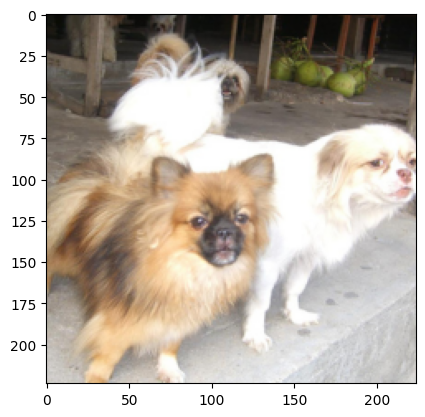

In [10]:
plt.imshow(inputs[0].permute(1, 2, 0).detach().cpu().numpy())

# Attributions

In [11]:
# model

In [12]:
# match MODEL_NAME:
#     case "resnet18":
#         last_conv_layer = model[1].layer4[-1]
#     case "vgg16":
#         last_conv_layer = model[1].features[-1]
#     case _:
#         raise ValueError(f"Model {MODEL_NAME} not supported")

In [13]:
from utils.model_analyzer import ModelAnalyzer, HeatmapUtils
from utils.attr_config import AttributionConfig
from captum.attr import Occlusion, LayerGradCam
from rise.rise import RISE

analyzer = ModelAnalyzer(model, inputs)
analyzer.forward_pass(idx_to_labels)

# conv_layers = ModelAnalyzer.find_layers_by_type(model, nn.Conv2d)
# last_conv_layer = conv_layers[-1]

rise_config = AttributionConfig(
    RISE,
    n_masks=4096,
    initial_mask_shapes=((4, 4),),
    blur_sigma=10.0,
    threshold=0.3,
    patience=64,
    d_epsilon=1e-3,
)

occlusion_config = AttributionConfig(
    attribution_class=Occlusion,
    sliding_window_shapes=(3, 32, 32),
    strides=(3, 16, 16),
    baselines=0,
    callback=lambda x: torch.clamp(x, min=0)[:, :1, :],
)
# x.abs().mean(1, keepdim=True),

gradcam_config = AttributionConfig(
    LayerGradCam,
    layer=last_conv_layer,
    relu_attributions=True,
)

try:
    if True:
        raise FileNotFoundError
    heatmap_rise = torch.load(f"{OUTPUT_PATH}/heatmap_rise.pt", map_location=DEVICE)
    heatmap_occ = torch.load(f"{OUTPUT_PATH}/heatmap_occ.pt", map_location=DEVICE)
    heatmap_gc = torch.load(f"{OUTPUT_PATH}/heatmap_gc.pt", map_location=DEVICE)
    activations = torch.load(f"{OUTPUT_PATH}/activations.pt", map_location=DEVICE)
except:
    heatmap_rise = analyzer.analyze(rise_config)
    heatmap_occ = analyzer.analyze(occlusion_config)
    heatmap_gc = analyzer.analyze(gradcam_config)
    activations = analyzer.get_activations(last_conv_layer, pool=True)

torch.save(heatmap_rise, f"{OUTPUT_PATH}/heatmap_rise.pt")
torch.save(heatmap_occ, f"{OUTPUT_PATH}/heatmap_occ.pt")
torch.save(heatmap_gc, f"{OUTPUT_PATH}/heatmap_gc.pt")
torch.save(activations, f"{OUTPUT_PATH}/activations.pt")

In [14]:
analyzer.predictions

[{'id': 154, 'label': 'Pekinese', 'score': 0.6802057027816772},
 {'id': 16, 'label': 'bulbul', 'score': 0.9999948740005493},
 {'id': 386, 'label': 'African_elephant', 'score': 0.45558246970176697},
 {'id': 160, 'label': 'Afghan_hound', 'score': 0.9993098974227905}]

In [15]:
heatmap_rise = heatmap_rise.unsqueeze(1)

In [16]:
if isinstance(last_conv_layer, nn.Conv2d):
    activations = -activations

In [17]:
from captum.attr import visualization as viz

In [18]:
# _ = viz.visualize_image_attr(
#     heatmap_rise[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="absolute_value",
#     cmap="jet",
#     show_colorbar=True,
# )

In [19]:
# _ = viz.visualize_image_attr(
#     heatmap_occ[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="positive",
#     cmap="jet",
#     show_colorbar=True,
# )

In [20]:
# _ = viz.visualize_image_attr(
#     heatmap_gc[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="positive",
#     cmap="jet",
#     show_colorbar=True,
# )

In [21]:
# _ = viz.visualize_image_attr(
#     activations[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="negative",
#     cmap="jet",
#     show_colorbar=True,
# )

In [22]:
heatmap_rise.shape, heatmap_occ.shape, heatmap_gc.shape, activations.shape

(torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 14, 14]),
 torch.Size([4, 1, 14, 14]))

In [23]:
upsample_shape = inputs.shape[-2:]
upsample_mode = "bicubic"

heatmap_rise = HeatmapUtils.upsample(heatmap_rise, upsample_shape, upsample_mode)
heatmap_occ = HeatmapUtils.upsample(heatmap_occ, upsample_shape, upsample_mode)
heatmap_gc = HeatmapUtils.upsample(heatmap_gc, upsample_shape, upsample_mode)
activations = HeatmapUtils.upsample(activations, upsample_shape, upsample_mode)

In [24]:
heatmap_rise.shape, heatmap_occ.shape, heatmap_gc.shape, activations.shape

(torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]))

In [25]:
(
    heatmap_rise.amin(dim=(1, 2, 3)),
    heatmap_rise.amax(dim=(1, 2, 3)),
    heatmap_occ.amin(dim=(1, 2, 3)),
    heatmap_occ.amax(dim=(1, 2, 3)),
    heatmap_gc.amin(dim=(1, 2, 3)),
    heatmap_gc.amax(dim=(1, 2, 3)),
    activations.amin(dim=(1, 2, 3)),
    activations.amax(dim=(1, 2, 3)),
)

(tensor([0.0724, 0.1359, 0.0258, 0.1535], device='cuda:0'),
 tensor([0.1159, 0.1791, 0.0432, 0.1772], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([0.6646, 0.1561, 0.3462, 0.2142], device='cuda:0'),
 tensor([    -0.0015,     -0.0000,     -0.0005,     -0.0000], device='cuda:0'),
 tensor([    0.0271,     0.0000,     0.0077,     0.0000], device='cuda:0'),
 tensor([2.0571, 1.2947, 1.9855, 1.6867], device='cuda:0'),
 tensor([23.1131, 26.0956, 10.9866, 16.1940], device='cuda:0'))

In [26]:
heatmap_rise = HeatmapUtils.normalize(heatmap_rise)
heatmap_occ = HeatmapUtils.normalize(heatmap_occ)
heatmap_gc = HeatmapUtils.normalize(heatmap_gc)
activations = HeatmapUtils.normalize(activations)

In [27]:
(
    heatmap_rise.amin(dim=(1, 2, 3)),
    heatmap_rise.amax(dim=(1, 2, 3)),
    heatmap_occ.amin(dim=(1, 2, 3)),
    heatmap_occ.amax(dim=(1, 2, 3)),
    heatmap_gc.amin(dim=(1, 2, 3)),
    heatmap_gc.amax(dim=(1, 2, 3)),
    activations.amin(dim=(1, 2, 3)),
    activations.amax(dim=(1, 2, 3)),
)

(tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000, 0.9713, 1.0000, 0.9996], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1.], device='cuda:0'))

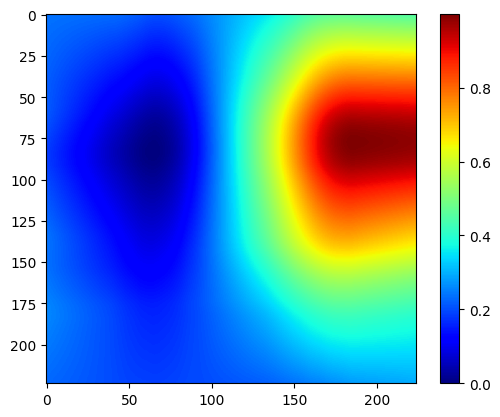

In [28]:
plt.imshow(heatmap_rise[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

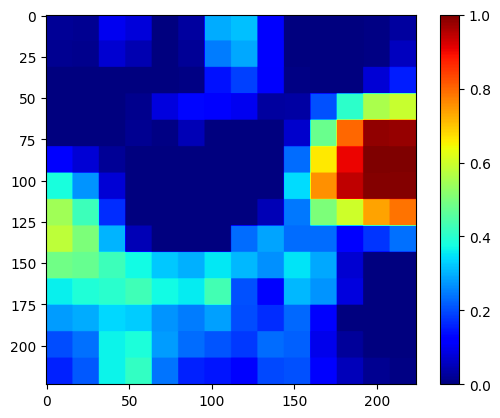

In [29]:
plt.imshow(heatmap_occ[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

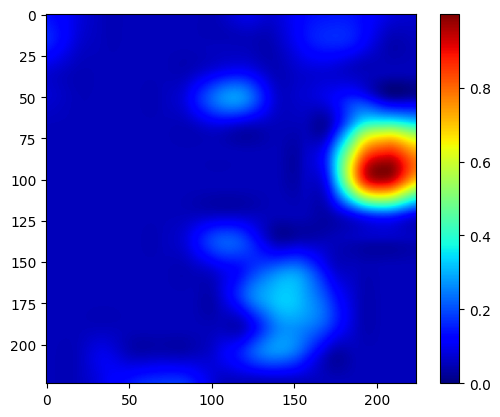

In [30]:
plt.imshow(heatmap_gc[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

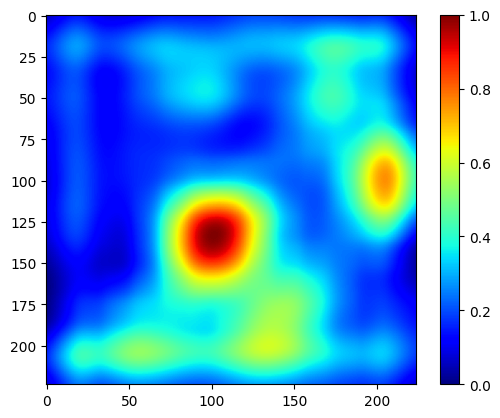

In [31]:
plt.imshow(activations[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

# Pixel Score

In [32]:
from IPython.display import HTML
from base64 import b64encode

from utils.video import VideoCallback
from pixel_score.pixel_score import PixelScore

In [33]:
SCORE_MODE = "erosion"
SCORE_THRESHOLD = 0.5

In [34]:
# heatmap_rise
vc = VideoCallback(cmap="gray")
metric = PixelScore(model, inputs, heatmap_rise, analyzer.targets, analyzer.scores)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_rise, ps_erosion_auc_rise = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_rise, ps_dilation_auc_rise = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_dilation.mp4")

In [35]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [36]:
# ps_erosion_curve_rise, ps_erosion_auc_rise

In [37]:
# heatmap_occ
vc = VideoCallback(cmap="gray")
metric = PixelScore(model, inputs, heatmap_occ, analyzer.targets, analyzer.scores)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_occ, ps_erosion_auc_occ = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_occ, ps_dilation_auc_occ = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_dilation.mp4")

In [38]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [39]:
# ps_erosion_curve_occ, ps_erosion_auc_occ

In [40]:
# heatmap_gc
vc = VideoCallback(cmap="gray")
metric = PixelScore(model, inputs, heatmap_gc, analyzer.targets, analyzer.scores)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_gc, ps_erosion_auc_gc = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_gc, ps_dilation_auc_gc = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_dilation.mp4")

In [41]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [42]:
# ps_erosion_curve_gc, ps_erosion_auc_gc

In [43]:
# activations
vc = VideoCallback(cmap="gray")
metric = PixelScore(model, inputs, activations, analyzer.targets, analyzer.scores)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_act, ps_erosion_auc_act = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/activations_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_act, ps_dilation_auc_act = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/activations_dilation.mp4")

In [44]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/activations_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [45]:
# ps_erosion_curve_act, ps_dilation_curve_act

# Plots

In [46]:
from matplotlib import ticker as tkr

In [47]:
def set_figsize(fig, n_rows, n_columns, width_per_column=1.2, height_per_row=1.2):
    width = n_columns * width_per_column
    height = n_rows * height_per_row
    fig.set_size_inches(width, height)


def plot_curve(ax, curve_data, auc_value, is_dilation=False):
    # Convertir a numpy y ordenar
    xy = curve_data.cpu().numpy()
    sorted_indices = np.argsort(xy[:, 0])
    x = xy[sorted_indices, 0]
    y = xy[sorted_indices, 1]

    # Filtrar valores de padding (1.0) manteniendo el último punto válido
    valid_mask = x < 1.0
    first_false_index = np.argmax(~valid_mask)
    valid_mask[first_false_index] = True  # Keep 1.0 accuracy
    if np.any(valid_mask):
        x = x[valid_mask]
        y = y[valid_mask]

    ax.plot(x, y, color="tab:blue", linewidth=1)
    ax.fill_between(x, y, alpha=0.3, color="tab:blue")

    ax.tick_params(labelsize=6)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter("%.2f"))

    if not is_dilation:
        ax.invert_xaxis()
        ax.axvline(x[-2], color="r", linestyle="--", linewidth=1)
    else:
        ax.set_ylim(0, 1)
        ax.set_xlim(SCORE_THRESHOLD, 1)

    ax.text(
        0.40,
        0.80,
        f"AUC: {auc_value:.2f}",
        transform=ax.transAxes,
        fontsize=7,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

/tmp/ipykernel_6117/2781962132.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.75, wspace=0.5)


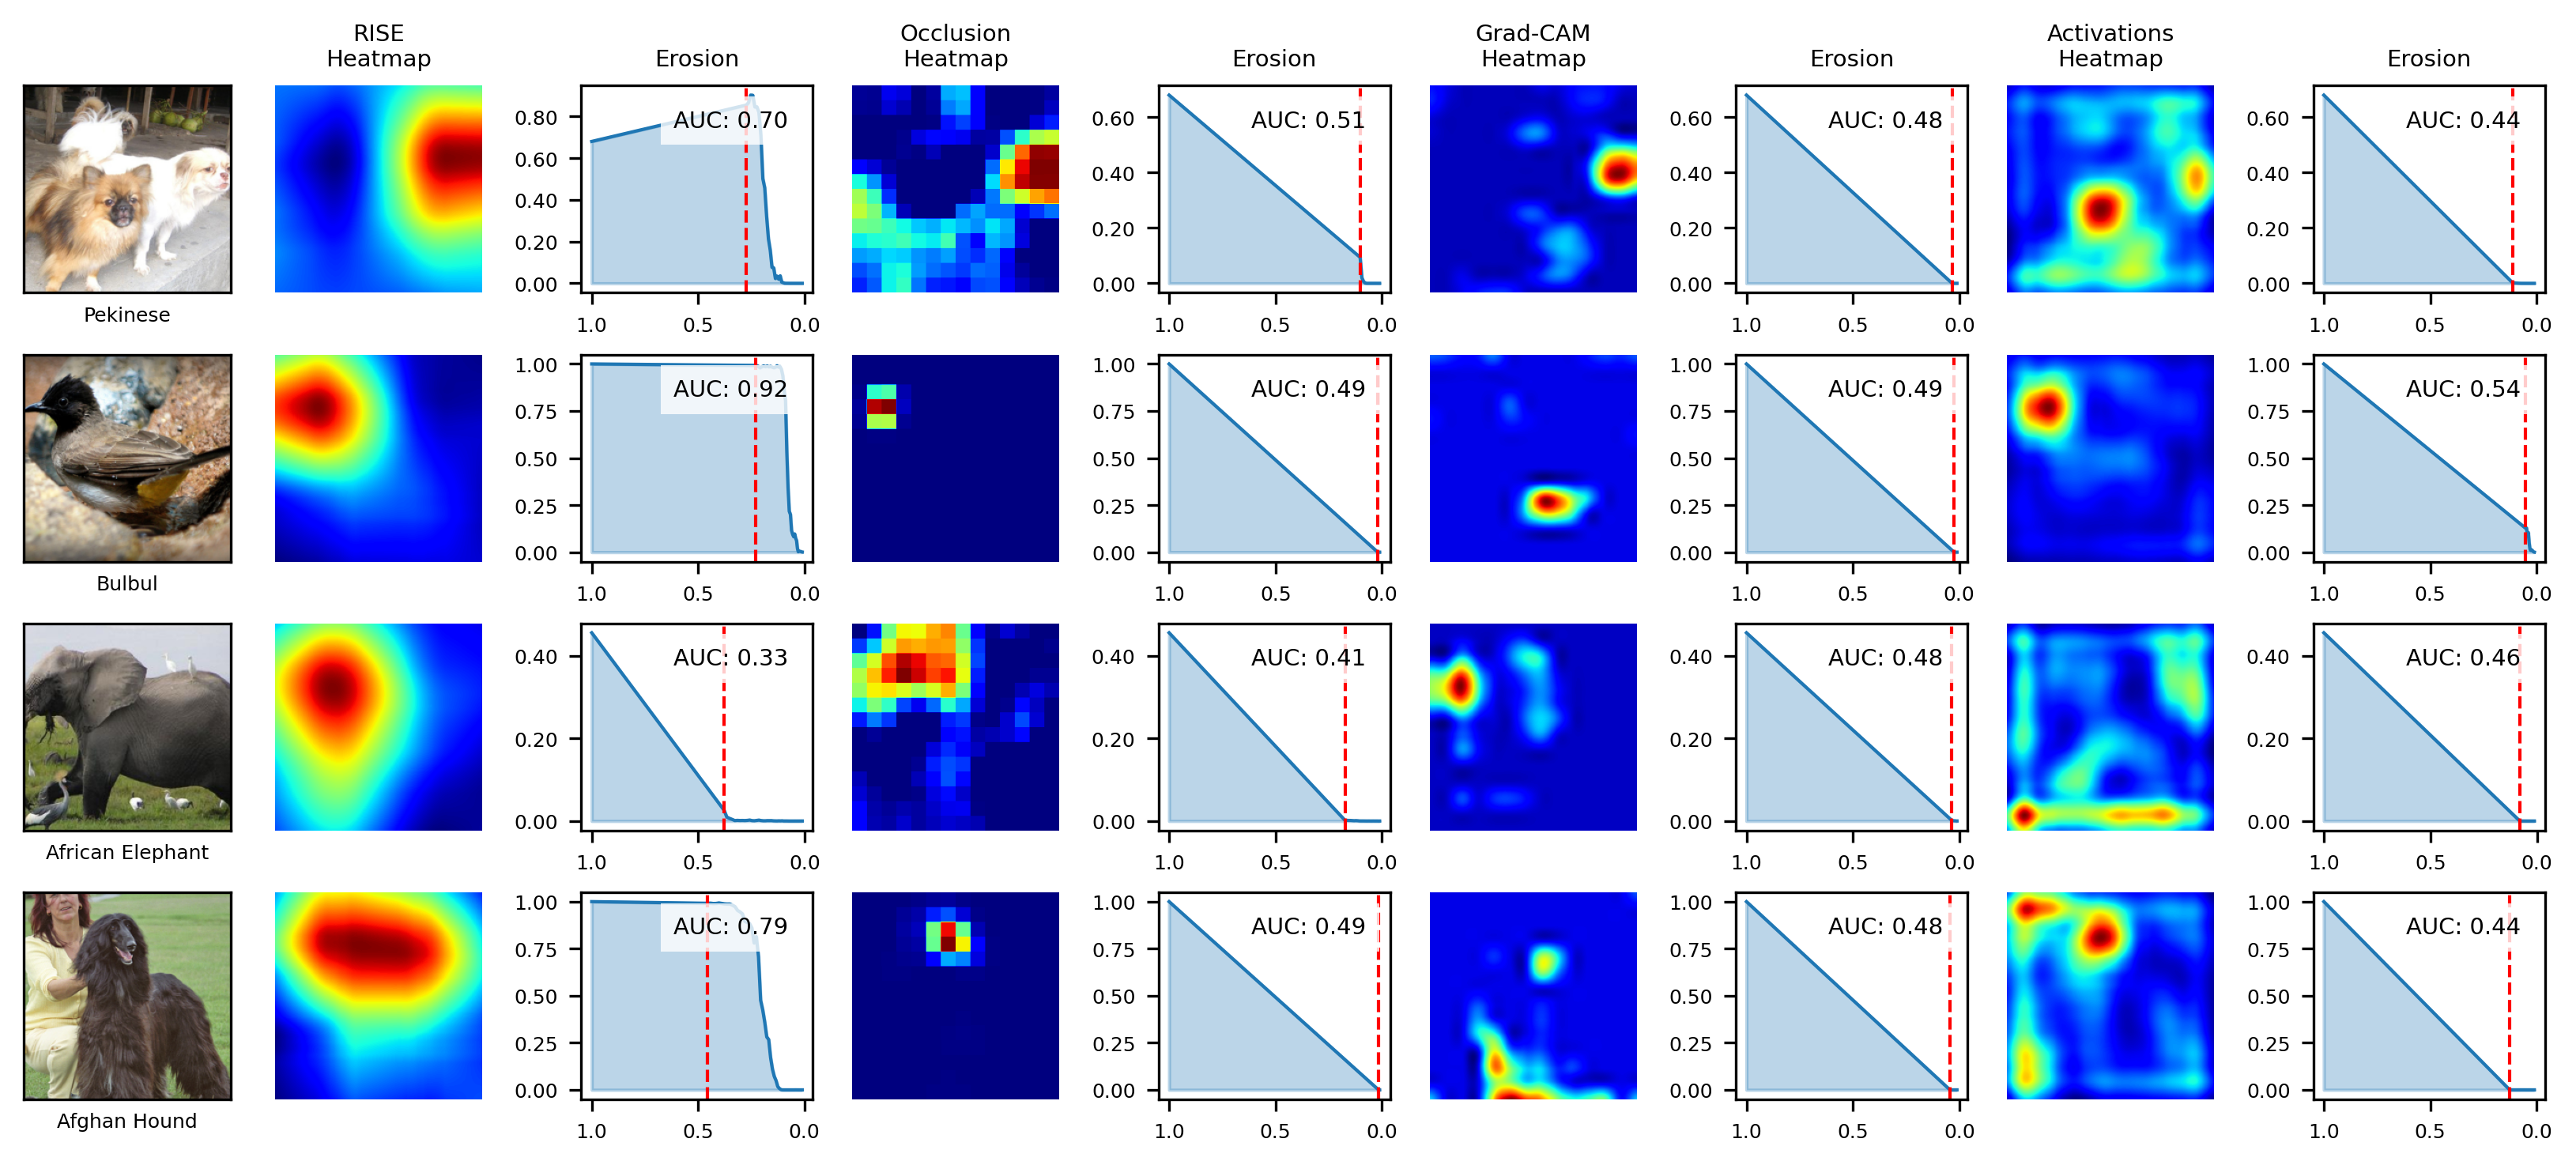

In [48]:
attributions = [
    (
        heatmap_rise,
        ps_erosion_curve_rise,
        ps_erosion_auc_rise,
    ),
    (
        heatmap_occ,
        ps_erosion_curve_occ,
        ps_erosion_auc_occ,
    ),
    (
        heatmap_gc,
        ps_erosion_curve_gc,
        ps_erosion_auc_gc,
    ),
    (
        activations,
        ps_erosion_curve_act,
        ps_erosion_auc_act,
    ),
]

cols = ["RISE", "Occlusion", "Grad-CAM", "Activations"]

fig, axes = plt.subplots(
    inputs.shape[0], len(attributions) * 2 + 1, constrained_layout=True
)
set_figsize(fig, inputs.shape[0], len(attributions) * 2 + 1)
fig.set_dpi(300)
fig.subplots_adjust(hspace=0.75, wspace=0.5)

for i in range(inputs.shape[0]):
    axes[i, 0].imshow(inputs[i].permute(1, 2, 0).detach().cpu().numpy())
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xlabel(
        f"{analyzer.predictions[i]['label'].replace('_', ' ').title()}", fontsize=6
    )

    for j, (attr, curve, auc) in enumerate(attributions):
        col_idx = j * 2 + 1

        im = axes[i, col_idx].imshow(attr[i][0].detach().cpu().numpy(), cmap="jet")
        axes[i, col_idx].axis("off")

        plot_curve(axes[i, col_idx + 1], curve[i], auc[i].item())

        if i == 0:
            axes[0, col_idx].set_title(f"{cols[j]}\nHeatmap", fontsize=7)
            axes[0, col_idx + 1].set_title("Erosion", fontsize=7)

plt.savefig(
    f"{OUTPUT_PATH}/attributions_scores_{len(inputs)}.jpg", dpi=300, bbox_inches="tight"
)
plt.show()